In [178]:
import numpy as np
import sympy as sp
from scipy.special import roots_legendre
import scipy.linalg as la
import matplotlib.pyplot as plt
from FEM import *
from tools import *
from shape_functions import *
# plt.style.use('default')
import copy


In [179]:
def Legendre(x=np.linspace(-1, 1, 100), p=5):

    if p == 0:
        return 1
    elif p == 1:
        return x

    else:
        return ((2*p-1)*x*Legendre(x, p-1)+(1-p)*Legendre(x, p-2))/p


In [180]:

class phi_func(shape_function):
    def __init__(self, scale, p):
        super().__init__(scale)
        self.p = p
    def expression(self, x):
        scale = self.scale
        i =self.p
        if i == 0:
            phi = (1-self.mapping(x))/2 
        elif i == 1:
            phi = (1+self.mapping(x))/2 
        else:
            phi = 1/np.sqrt(4*i-2)*(Legendre(self.mapping(x), i)-Legendre(self.mapping(x), i-2))
        return phi
        
class phip_func(phi_func):
    def expression(self, x):
        scale_up = 2/(self.scale[1]-self.scale[0]) 
        i =self.p
        
        if i == 0:
            phip =  np.zeros_like(self.mapping(x))-0.5
        elif i == 1:
            phip = np.zeros_like(self.mapping(x))+0.5
        else:
            phip = np.sqrt(i-1/2)*(Legendre(self.mapping(x), i-1))
        return phip*scale_up
    
def Hierarchical(scale, p):
    phis = []
    phips = []
    start=0
    
    for i in range(start, p+1):
        new_phi = phi_func(scale, i)
        new_phip = phip_func(scale,i)
        phis.append(new_phi)
        phips.append(new_phip)
    return phis, phips

In [181]:
def joint_funcs(functions):
    if type(functions) != list:
        raise AssertionError("Inputs must be a list!")
    elif not callable(functions[0]):
        raise AssertionError("Elements in the list must be functions!")
    new_lst = [plus(functions[i], functions[i+1]) for i in range(1, len(functions)-1, 2)]
    new_lst.insert(0, functions[0])  # 把第一个元素插入到新列表的首位
    new_lst.append(functions[-1])
    
    return new_lst

In [182]:
domain = (0, 1)
N = 6
num_elems = 2
BCs = (0, 0)

p = 3
def p_FEM(shape_class = Hierarchical, p = p, num_elems = 3, domain = (0, 1),rhs_func = rhs_fn(a=50, xb=0.8), exact_func=exact_fn(0.5,0.8), BCs = (0, 0), verbose = False):
    mesh = np.linspace(domain[0], domain[1], num_elems+1)
    ori_phi_phip = {'phis': [], 'phips': []}
    for elem in range(num_elems):
        scale = [mesh[elem], mesh[elem+1]]
        phis, phips = Hierarchical(scale, p)
        ori_phi_phip['phis'].append(phis)
        ori_phi_phip['phips'].append(phips)


    linear_phi_phip = {'phis': [], 'phips': []}  # Linear
    for elem in range(num_elems):
        linear_phis = []
        linear_phips = []
        for idx in range(len(ori_phi_phip['phis'][elem])):
            if ori_phi_phip['phis'][elem][idx].p < 2:
                phi = ori_phi_phip['phis'][elem][idx]
                phip = ori_phi_phip['phips'][elem][idx]
                linear_phi_phip['phis'].append(phi)
                linear_phi_phip['phips'].append(phip)
                linear_phis.append(phi)
                linear_phips.append(phip)
        linear_K_sub = np.zeros((len(linear_phips), len(linear_phips)))
        for indx, x in np.ndenumerate(linear_K_sub):
            linear_K_sub[indx] = G_integrate(
                mul(linear_phips[indx[0]], linear_phips[indx[-1]]), N=6, scale=linear_phips[indx[0]].scale)
            if abs(linear_K_sub[indx]) < 1e-10:
                linear_K_sub[indx] = 0
        # print('K_sub', K_sub)
        linear_F_sub = np.zeros(len(linear_K_sub))
        for indx in range(len(linear_F_sub)):
            linear_F_sub[indx] = G_integrate(
                mul(rhs_func, linear_phis[indx]), N=N, scale=linear_phis[indx].scale)
            # print(phis[indx](mesh[i]))
        if elem == 0:
            K = linear_K_sub
            F = linear_F_sub
        else:
            K = assemble(K, linear_K_sub)
            F = assemble(F, linear_F_sub)
            
    # Applying boundary condition
    K[0, 1:] = 0.0 
    K[-1, :-1] = 0.0
    F[0] = BCs[0]* K[0, 0] # -= or = ??
    F[-1] = BCs[-1] * K[-1, -1]

    nonlinear_phi_phip = {'phis': [], 'phips': []}
    for order in range(2, p+1):  # Non Linear
        # print('order', order)
        for elem in range(num_elems):
            for idx in range(len(ori_phi_phip['phis'][elem])):
                if (ori_phi_phip['phis'][elem][idx].p == order) or (ori_phi_phip['phips'][elem][idx].p == order):
                    nonlinear_phi = ori_phi_phip['phis'][elem][idx]
                    nonlinear_phip = ori_phi_phip['phips'][elem][idx]
                    nonlinear_phi_phip['phis'].append(nonlinear_phi)
                    nonlinear_phi_phip['phips'].append(nonlinear_phip)
                    nonlinear_K_sub = np.zeros((2, 2))
                    # print('nonlinear_phip', nonlinear_phip.p)
                    # print(G_integrate(mul(nonlinear_phip, nonlinear_phip),N=N, scale=nonlinear_phip.scale))
                    
                    nonlinear_K_sub[-1, -1] = G_integrate(mul(nonlinear_phip, nonlinear_phip),N=N, scale=nonlinear_phip.scale)
                    nonlinear_F_sub = np.zeros(2)
                    nonlinear_F_sub[-1] = G_integrate(mul(rhs_func, nonlinear_phi), N=N, scale=nonlinear_phi.scale)

                    K = assemble(K, nonlinear_K_sub)
                    F = assemble(F, nonlinear_F_sub)
                else:
                    pass

    U = -la.solve(K, F)
    # print(F)
    phi_phip = {'phis': [], 'phips': []}
    phi_phip['phis'] = joint_funcs(linear_phi_phip['phis']) + nonlinear_phi_phip['phis']
    phi_phip['phips'] = joint_funcs(linear_phi_phip['phips']) + nonlinear_phi_phip['phips']
    u_list = []
    for i in range(len(phi_phip['phis'])):
        u_list.append(mul(U[i], phi_phip['phis'][i]))
    uh = plus(u_list)
    if verbose == True:
        print(f"Shape class: {shape_class.__name__}, Number of elements: {num_elems}, Polynomial order:{p},  Domain: {domain}, Boundary conditions: {BCs}")
        x_data = np.linspace(domain[0], domain[1], 101)
        plt.plot(x_data, exact_func(x_data), label='Analytical solution')
        plt.plot(x_data, uh(x_data), label='FEM solution {} elements'.format(num_elems))
        for i in range(len(phi_phip['phis'])):
            func = phi_phip['phis'][i]
            plt.plot(x_data, U[i]*func(x_data))
        plt.legend()
        plt.show()
    return U, phi_phip, uh


Shape class: Hierarchical, Number of elements: 5, Polynomial order:5,  Domain: (0, 1), Boundary conditions: (0.0, 0.0)


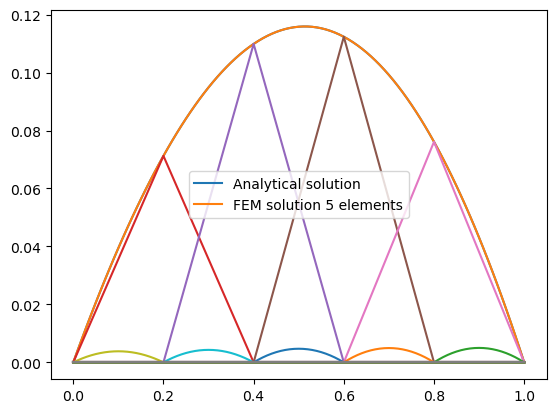

0.03559183824569155

In [183]:
num_elems =5
p = 5
domain = (0, 1)
mesh = np.linspace(domain[0], domain[1], num_elems+1)
a = .5*1 

xb = 0.8
if a == 50:
    U_init = 1.585854059271320
elif a == 0.5:
    U_init = 0.03559183822564316

exact_func = exact_fn(a = a, xb=xb)
rhs_func = rhs_fn(a=a, xb=xb)
BCs = (exact_func(domain[0]), exact_func(domain[-1]))


def cal_energy(U_array, phi_phip_array):
    U_energy = 0
    u_prime_list = []
    scales = []
    for i in range(len(phi_phip_array['phis'])):
        u_prime = mul(U_array[i], phi_phip_array['phips'][i])
        u_prime_list.append(u_prime)
        scales.append(u_prime.scale)
    # 首先，把嵌套的列表变为一个扁平的列表
    flat_scales = [item for sublist in scales for item in sublist]

    # 然后，把所有的值都保留到五位小数
    rounded_scales = [round(num, 5) for num in flat_scales]

    # 现在，用 set 来获取所有的唯一值
    nodes = list(set(rounded_scales))
    mesh = np.linspace(min(nodes), max(nodes), len(nodes))
    # print(mesh)
    for i in range(len(mesh)-1):
        scale = [mesh[i], mesh[i+1]]
        U_energy+=G_integrate(mul(plus(u_prime_list), plus(u_prime_list)),N=60, scale=scale)


    return U_energy/2

U_p, phi_phip_p, uh_p = p_FEM(shape_class = Hierarchical, p = p, num_elems = num_elems, domain = domain,rhs_func = rhs_func,exact_func=exact_func, BCs = BCs, verbose = True)
cal_energy(U_p, phi_phip_p)


[6, 11, 16, 21, 26]
[0.1981931248998076, 0.001932890648942523, 6.612201425120033e-05, 2.369606245439507e-05, 2.3733652514787582e-05]


Text(0.5, 1.0, 'Log-log plot for DOF versus energy norm error')

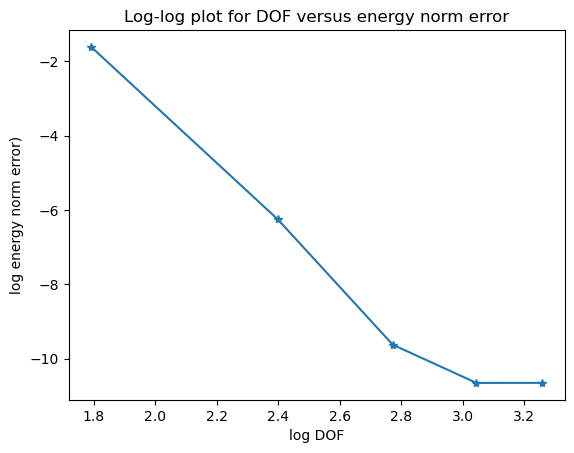

In [184]:
energ_norm_error_list_p = []
DOF_p = []
num_elems = 5
domain = (0, 1)
mesh = np.linspace(domain[0], domain[1], num_elems+1)
a = .5*1 

xb = 0.8
if a == 50.:
    U_init = 1.585854059271320
elif a == 0.5:
    U_init = 0.03559183822564316
    
exact_func = exact_fn(a = a, xb=xb)
rhs_func = rhs_fn(a=a, xb=xb)
BCs = (exact_func(domain[0]), exact_func(domain[-1]))
p_list = np.linspace(1, 5, 5)
for i in range(len(p_list)):
    p = int(p_list[i])
    U_p, phi_phip_p, uh_p = p_FEM(shape_class = Hierarchical, p = p, num_elems = num_elems, domain = domain,rhs_func = rhs_func,exact_func=exact_func, BCs = BCs, verbose = False)
    energy_p = cal_energy(U_p, phi_phip_p)
    # print('energy_p', energy_p)
    # print('U_init', U_init)
    energ_norm_error = np.sqrt(abs(energy_p-U_init)/U_init)
    energ_norm_error_list_p.append(energ_norm_error)
    DOF_p.append(len(U_p))
truncate = 0
print(DOF_p)
print(energ_norm_error_list_p)
plt.plot(np.log(DOF_p[truncate:]), np.log(energ_norm_error_list_p[truncate:]), '*-')
plt.xlabel('log DOF')
plt.ylabel('log energy norm error)')
plt.title('Log-log plot for DOF versus energy norm error')